In [40]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

In [41]:
X = np.load("../processed/X_metadata.npy")
y_privacy = np.load("../processed/y_privacy.npy")

print("X shape:", X.shape)
print("y_privacy shape:", y_privacy.shape)

X shape: (10000, 62)
y_privacy shape: (10000, 4)


In [42]:
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y_privacy, dtype=torch.float32)

X_train, X_val, y_train, y_val = train_test_split(
    X_tensor, y_tensor, test_size=0.2, random_state=42
)

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=64, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=64)

In [43]:
class PrivacyPredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, output_dim=4):
        super(PrivacyPredictor, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)  # Raw logits

In [44]:
model = PrivacyPredictor(input_dim=X.shape[1])
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [45]:
EPOCHS = 100
f1_scores = []

for epoch in range(EPOCHS):
    model.train()
    for xb, yb in train_loader:
        logits = model(xb)
        loss = criterion(logits, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    all_preds, all_true = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            probs = torch.sigmoid(model(xb))
            preds = (probs > 0.5).int().cpu().numpy()
            all_preds.append(preds)
            all_true.append(yb.cpu().numpy())
    
    all_preds = np.vstack(all_preds)
    all_true = np.vstack(all_true)
    f1 = f1_score(all_true, all_preds, average="micro")
    f1_scores.append(f1)
    print(f"Epoch {epoch+1}/{EPOCHS} — F1 Score: {f1:.4f}")


Epoch 1/100 — F1 Score: 0.7367
Epoch 2/100 — F1 Score: 0.7543
Epoch 3/100 — F1 Score: 0.7576
Epoch 4/100 — F1 Score: 0.7594
Epoch 5/100 — F1 Score: 0.7607
Epoch 6/100 — F1 Score: 0.7613
Epoch 7/100 — F1 Score: 0.7643
Epoch 8/100 — F1 Score: 0.7634
Epoch 9/100 — F1 Score: 0.7638
Epoch 10/100 — F1 Score: 0.7667
Epoch 11/100 — F1 Score: 0.7621
Epoch 12/100 — F1 Score: 0.7620
Epoch 13/100 — F1 Score: 0.7649
Epoch 14/100 — F1 Score: 0.7657
Epoch 15/100 — F1 Score: 0.7645
Epoch 16/100 — F1 Score: 0.7633
Epoch 17/100 — F1 Score: 0.7632
Epoch 18/100 — F1 Score: 0.7644
Epoch 19/100 — F1 Score: 0.7621
Epoch 20/100 — F1 Score: 0.7633
Epoch 21/100 — F1 Score: 0.7672
Epoch 22/100 — F1 Score: 0.7630
Epoch 23/100 — F1 Score: 0.7645
Epoch 24/100 — F1 Score: 0.7662
Epoch 25/100 — F1 Score: 0.7653
Epoch 26/100 — F1 Score: 0.7611
Epoch 27/100 — F1 Score: 0.7636
Epoch 28/100 — F1 Score: 0.7618
Epoch 29/100 — F1 Score: 0.7611
Epoch 30/100 — F1 Score: 0.7668
Epoch 31/100 — F1 Score: 0.7625
Epoch 32/100 — F1

In [46]:
model.eval()
all_preds, all_probs, all_true = [], [], []

with torch.no_grad():
    for xb, yb in val_loader:
        logits = model(xb)
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).int()
        
        all_probs.append(probs.cpu().numpy())
        all_preds.append(preds.cpu().numpy())
        all_true.append(yb.cpu().numpy())

all_probs = np.vstack(all_probs)
all_preds = np.vstack(all_preds)
all_true = np.vstack(all_true)


In [ ]:
from sklearn.metrics import classification_report

import pickle
with open("../processed/mlb_privacy.pkl", "rb") as f:
    mlb_privacy = pickle.load(f)

print(classification_report(
    all_true, all_preds, 
    target_names=mlb_privacy.classes_,
    zero_division=0
))


                        precision    recall  f1-score   support

    Data Linked to You       0.74      0.79      0.76       890
    Data Not Collected       0.68      0.82      0.74       555
Data Not Linked to You       0.72      0.77      0.74      1124
Data Used to Track You       0.77      0.84      0.80       839

             micro avg       0.73      0.80      0.76      3408
             macro avg       0.73      0.81      0.76      3408
          weighted avg       0.73      0.80      0.76      3408
           samples avg       0.68      0.76      0.70      3408



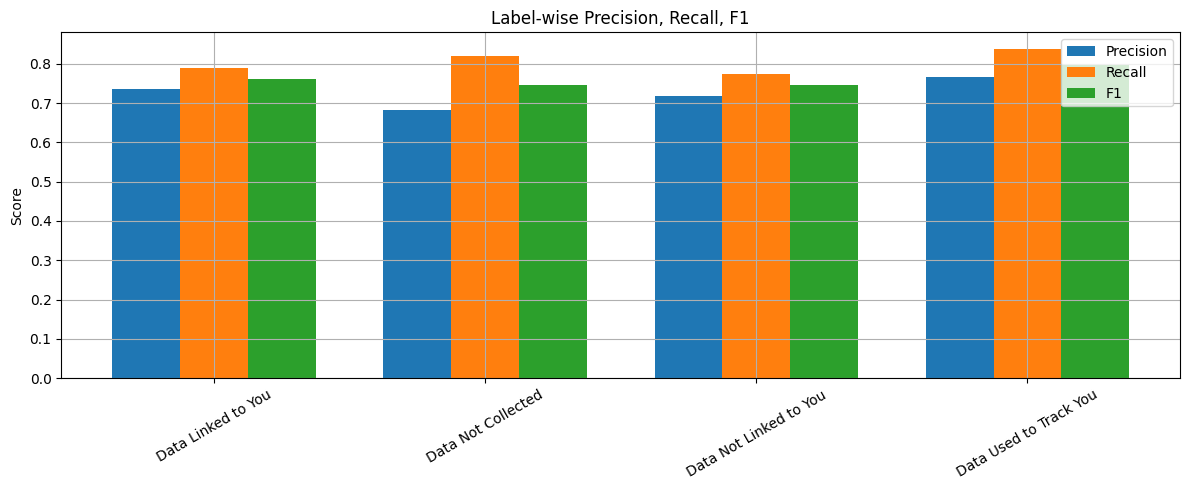

In [48]:
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt

prec, rec, f1, _ = precision_recall_fscore_support(all_true, all_preds, zero_division=0)
labels = mlb_privacy.classes_

x = np.arange(len(labels))
width = 0.25

plt.figure(figsize=(12, 5))
plt.bar(x - width, prec, width, label='Precision')
plt.bar(x, rec, width, label='Recall')
plt.bar(x + width, f1, width, label='F1')

plt.xticks(x, labels, rotation=30)
plt.ylabel("Score")
plt.title("Label-wise Precision, Recall, F1")
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()
